In [12]:
import pandas as pd
import glob
import os
import numpy as np

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# --- CONFIGURATION ---
MAIN_DIR = r'C:\Users\akinb\Downloads\Intro to AI Project\data'

# --- 1. DATA LOADING FUNCTION (Reused from your notebook) ---
def load_and_stack_data(main_dir, table_name):
    search_pattern = os.path.join(main_dir, f'*{table_name}*.csv')
    file_list = glob.glob(search_pattern, recursive=True)
    
    if not file_list:
        print(f"Warning: No files found for table '{table_name}'.")
        return pd.DataFrame()

    print(f"Found {len(file_list)} files for {table_name}. Loading...")
    all_dfs = []
    for file in file_list:
        try:
            # low_memory=False handles mixed types in large files
            df = pd.read_csv(file, low_memory=False)
            all_dfs.append(df)
        except Exception as e:
            print(f"   Error loading {os.path.basename(file)}: {e}")
    
    master_df = pd.concat(all_dfs, ignore_index=True)
    
    # Standardize CRN for merging
    if 'CRN' in master_df.columns:
        master_df['CRN'] = master_df['CRN'].astype(str).str.strip()
        
    return master_df

# --- 2. LOAD TABLES ---
print("--- Loading Data ---")
df_crash = load_and_stack_data(MAIN_DIR, 'CRASH')
df_flag = load_and_stack_data(MAIN_DIR, 'FLAG')
df_person = load_and_stack_data(MAIN_DIR, 'PERSON')
df_vehicle = load_and_stack_data(MAIN_DIR, 'VEHICLE')

# --- 3. PREPARE CRASH TABLE (TARGET & CONTEXT) ---
print("\n--- Processing CRASH Table ---")

# Define Target Variable: Severe (1, 2) vs Non-Severe (0, 3, 4, 8)
# Note: We treat 0 (Property Damage), 3 (Minor), 4 (Possible), 8(Injury -  severity) as Class 0
# We treat 1 (Fatal), 2 (Suspected Serious) as Class 1
def classify_severity(val):
    try:
        val = int(val)
        if val in [1, 2]: 
            return 1 # Severe
        elif val in [0, 3, 4, 8]: 
            return 0 # Non-Severe
        else: 
            return np.nan # Unknowns (9)
    except:
        return np.nan

df_crash['TARGET_SEVERE'] = df_crash['MAX_SEVERITY_LEVEL'].apply(classify_severity)

# Filter out rows where target is unknown (if any)
df_crash = df_crash.dropna(subset=['TARGET_SEVERE'])

# Select features from CRASH table (Environmental & Temporal)
# Note: CRASH table already has some aggregated counts (Heavy Truck count, etc.) which is helpful.
crash_cols = [
    'CRN', 'CRASH_YEAR', 'CRASH_MONTH', 'COUNTY', 'TARGET_SEVERE', 'LONGITUDE', 'LATITUDE', 'DEC_LONG', 'DEC_LAT', 'ROAD_CONDITION', 'URBAN_RURAL', 
    'SPEED_LIMIT', 'LANE_COUNT', 'FATIGUE_ASLEEP', # Often in crash or flag
    'AUTOMOBILE_COUNT', 'HEAVY_TRUCK_COUNT', 'MOTORCYCLE_COUNT', 
    'SUV_COUNT', 'VAN_COUNT', 'UNBELTED_OCC_COUNT'
]

# Keep only columns that actually exist in the dataframe to avoid errors
existing_crash_cols = [c for c in crash_cols if c in df_crash.columns]
df_master = df_crash[existing_crash_cols].copy()

# --- 4. PREPARE FLAG TABLE (RISK INDICATORS) ---
print("--- Processing FLAG Table ---")
# FLAG table is 1:1 with CRASH, so we just select the interesting columns
flag_cols = [
    'CRN', 'ALCOHOL_RELATED', 'DRINKING_DRIVER', 'DRUG_RELATED', 'DRUGGED_DRIVER', 'ILLEGAL_DRUG_RELATED', 'IMPAIRED_DRIVER', 'IMPAIRED_NONMOTORIST', 'MARIJUANA_DRUGGED_DRIVER', 'MARIJUANA_RELATED', 'MC_DRINKING_DRIVER', 'OPIOID_RELATED', 'UNDERAGE_DRNK_DRV', 'AGGRESSIVE_DRIVING', 'NHTSA_AGG_DRIVING', 'SPEEDING', 'SPEEDING_RELATED', 'TAILGATING', 'NO_CLEARANCE', 'CELL_PHONE', 'DISTRACTED', 'FATIGUE_ASLEEP', 'RUNNING_RED_LT', 'RUNNING_STOP_SIGN', 'LEFT_TURN', 'CURVE_DVR_ERROR', 'LANE_DEPARTURE', 'UNBELTED', 'UNLICENSED', 'ICY_ROAD', 'SNOW_SLUSH_ROAD', 'WET_ROAD', 'ILLUMINATION_DARK', 'BACKUP_CONGESTION', 'BACKUP_NONRECURRING', 'BACKUP_PRIOR', 'WORK_ZONE', 'INTERSTATE', 'TURNPIKE', 'STATE_ROAD', 'LOCAL_ROAD', 'LOCAL_ROAD_ONLY', 'FEDERAL_AID_ROUTE', 'CORE_NETWORK', 'OTHER_FREEWAY', 'CURVED_ROAD', 'RAMP', 'RAMP_SEGMENT', 'RAMP_TERMINAL', 'SPEED_CHANGE_LANE', 'INTERSECTION', 'INTERSECTION_RELATED', 'NON_INTERSECTION', 'SIGNALIZED_INT', 'STOP_CONTROLLED_INT', 'UNSIGNALIZED_INT', 'ROUNDABOUT', 'SCHOOL_ZONE', 'URBAN', 'RURAL', 'SHLDR_RELATED', 'ATV_ROUTE', 'LIMIT_65MPH', 'LIMIT_70MPH', 'ANGLE_CRASH', 'REAR_END', 'HO_OPPDIR_SDSWP', 'OVERTURNED', 'SINGLE_VEHICLE', 'MULTIPLE_VEHICLE', 'CROSS_MEDIAN', 'COMM_VEHICLE', 'HAZARDOUS_TRUCK', 'HVY_TRUCK_RELATED', 'SCHOOL_BUS', 'SCHOOL_BUS_RELATED', 'SCHOOL_BUS_UNIT', 'MOTORCYCLE', 'BICYCLE', 'TRAIN', 'TROLLEY', 'TRAIN_TROLLEY', 'SNOWMOBILE', 'ATV', 'HORSE_BUGGY', 'PHANTOM_VEHICLE', 'VULNERABLE_ROADWAY_USER', 'DEER_RELATED', 'HIT_DEER', 'SUDDEN_DEER', 'YOUNG_DRIVER', 'MATURE_DRIVER', 'DRIVER_16YR', 'DRIVER_75PLUS', 'VEHICLE_FAILURE'
]
existing_flag_cols = [c for c in flag_cols if c in df_flag.columns]
df_flag_subset = df_flag[existing_flag_cols].copy()

# Merge FLAG into Master
df_master = df_master.merge(df_flag_subset, on='CRN', how='left')
# Fill NaNs in flags with 0 (assuming missing flag means attribute is not present)
flag_features = [c for c in existing_flag_cols if c != 'CRN']
df_master[flag_features] = df_master[flag_features].fillna(0)

'''
# --- 5. AGGREGATE PERSON DATA (The Flattening Step) ---
print("--- Aggregating PERSON Data ---")

# Pre-processing: Clean Age (99 is unknown)
df_person['AGE'] = pd.to_numeric(df_person['AGE'], errors='coerce')
# Replace 99 or illogical ages with NaN for calculation
df_person.loc[df_person['AGE'] > 98, 'AGE'] = np.nan

# Filter for DRIVERS only (Person Type 1) to get driver demographics
df_drivers = df_person[df_person['PERSON_TYPE'] == '1'].copy()

# 5a. Aggregations per crash
person_agg = df_drivers.groupby('CRN').agg({
    'AGE': ['max', 'min'],   # Age of oldest and youngest driver
    'SEX': [
        lambda x: (x == 'M').sum(), # Count of Male Drivers
        lambda x: (x == 'F').sum()  # Count of Female Drivers
    ]
})

# Flatten MultiIndex columns
person_agg.columns = ['DRIVER_AGE_MAX', 'DRIVER_AGE_MIN', 'DRIVER_COUNT_MALE', 'DRIVER_COUNT_FEMALE']
person_agg = person_agg.reset_index()

# Merge Person Aggregations into Master
df_master = df_master.merge(person_agg, on='CRN', how='left')

'''

'''
# --- 6. AGGREGATE VEHICLE DATA ---
print("--- Aggregating VEHICLE Data ---")
# While CRASH table has counts, VEHICLE table has Model Year which indicates vehicle age
# Calculate Vehicle Age: (Current Year - Model Year)
# Note: Using CRASH_YEAR from CRASH table would be more precise, but using a static year is a fair proxy for now.
# Let's try to extract basic "Age of Fleet" info.

df_vehicle['MODEL_YR'] = pd.to_numeric(df_vehicle['MODEL_YR'], errors='coerce')
# Filter out bad years (e.g. > current year or < 1900)
df_vehicle = df_vehicle[(df_vehicle['MODEL_YR'] > 1900) & (df_vehicle['MODEL_YR'] < 2026)]

vehicle_agg = df_vehicle.groupby('CRN').agg({
    'MODEL_YR': ['min', 'mean'] # Oldest vehicle involved, Average age of vehicles
})

vehicle_agg.columns = ['VEHICLE_YEAR_OLDEST', 'VEHICLE_YEAR_AVG']
vehicle_agg = vehicle_agg.reset_index()

# Merge Vehicle Aggregations into Master
df_master = df_master.merge(vehicle_agg, on='CRN', how='left')
'''

# --- 7. FINAL CLEANUP ---
print("\n--- Finalizing Dataset ---")
'''
# Aggregation merges will create NaNs for crashes involving 0 people/vehicles of that type
# (e.g., hit and run might have no person data).
fillna_cols = ['DRIVER_COUNT_MALE', 'DRIVER_COUNT_FEMALE']
df_master[fillna_cols] = df_master[fillna_cols].fillna(0)

# For Ages/Years, NaNs likely mean unknown. We can leave them as NaN for XGBoost (which handles them) 
# or impute them. For now, we leave them as NaN.
'''
print(f"Final Flattened Dataset Shape: {df_master.shape}")
print("Columns:", df_master.columns.tolist())

# Save
#df_master.to_csv(os.path.join(MAIN_DIR, 'pa_crash_data_ml_ready.csv'), index=False)

--- Loading Data ---
Found 20 files for CRASH. Loading...
Found 20 files for FLAG. Loading...
Found 20 files for PERSON. Loading...
Found 20 files for VEHICLE. Loading...

--- Processing CRASH Table ---
--- Processing FLAG Table ---

--- Finalizing Dataset ---
Final Flattened Dataset Shape: (2387466, 107)
Columns: ['CRN', 'CRASH_YEAR', 'CRASH_MONTH', 'COUNTY', 'TARGET_SEVERE', 'LONGITUDE', 'LATITUDE', 'ROAD_CONDITION', 'URBAN_RURAL', 'AUTOMOBILE_COUNT', 'HEAVY_TRUCK_COUNT', 'MOTORCYCLE_COUNT', 'SUV_COUNT', 'VAN_COUNT', 'UNBELTED_OCC_COUNT', 'ALCOHOL_RELATED', 'DRINKING_DRIVER', 'DRUG_RELATED', 'DRUGGED_DRIVER', 'ILLEGAL_DRUG_RELATED', 'IMPAIRED_DRIVER', 'IMPAIRED_NONMOTORIST', 'MARIJUANA_DRUGGED_DRIVER', 'MARIJUANA_RELATED', 'MC_DRINKING_DRIVER', 'OPIOID_RELATED', 'UNDERAGE_DRNK_DRV', 'AGGRESSIVE_DRIVING', 'NHTSA_AGG_DRIVING', 'SPEEDING', 'SPEEDING_RELATED', 'TAILGATING', 'NO_CLEARANCE', 'CELL_PHONE', 'DISTRACTED', 'FATIGUE_ASLEEP', 'RUNNING_RED_LT', 'RUNNING_STOP_SIGN', 'LEFT_TURN', '

In [13]:
df_master.head()

,CRN,CRASH_YEAR,CRASH_MONTH,COUNTY,TARGET_SEVERE,LONGITUDE,LATITUDE,ROAD_CONDITION,URBAN_RURAL,AUTOMOBILE_COUNT,HEAVY_TRUCK_COUNT,MOTORCYCLE_COUNT,SUV_COUNT,VAN_COUNT,UNBELTED_OCC_COUNT,ALCOHOL_RELATED,DRINKING_DRIVER,DRUG_RELATED,DRUGGED_DRIVER,ILLEGAL_DRUG_RELATED,IMPAIRED_DRIVER,IMPAIRED_NONMOTORIST,MARIJUANA_DRUGGED_DRIVER,MARIJUANA_RELATED,MC_DRINKING_DRIVER,OPIOID_RELATED,UNDERAGE_DRNK_DRV,AGGRESSIVE_DRIVING,NHTSA_AGG_DRIVING,SPEEDING,SPEEDING_RELATED,TAILGATING,NO_CLEARANCE,CELL_PHONE,DISTRACTED,FATIGUE_ASLEEP,RUNNING_RED_LT,RUNNING_STOP_SIGN,LEFT_TURN,CURVE_DVR_ERROR,LANE_DEPARTURE,UNBELTED,UNLICENSED,ICY_ROAD,SNOW_SLUSH_ROAD,WET_ROAD,ILLUMINATION_DARK,BACKUP_CONGESTION,BACKUP_NONRECURRING,BACKUP_PRIOR,WORK_ZONE,INTERSTATE,TURNPIKE,STATE_ROAD,LOCAL_ROAD,LOCAL_ROAD_ONLY,FEDERAL_AID_ROUTE,CORE_NETWORK,CURVED_ROAD,RAMP,RAMP_SEGMENT,RAMP_TERMINAL,SPEED_CHANGE_LANE,INTERSECTION,INTERSECTION_RELATED,NON_INTERSECTION,SIGNALIZED_INT,STOP_CONTROLLED_INT,UNSIGNALIZED_INT,ROUNDABOUT,SCHOOL_ZONE,URBAN,RURAL,SHLDR_RELATED,ATV_ROUTE,LIMIT_65MPH,LIMIT_70MPH,ANGLE_CRASH,REAR_END,HO_OPPDIR_SDSWP,OVERTURNED,SINGLE_VEHICLE,MULTIPLE_VEHICLE,CROSS_MEDIAN,COMM_VEHICLE,HAZARDOUS_TRUCK,HVY_TRUCK_RELATED,SCHOOL_BUS,SCHOOL_BUS_RELATED,SCHOOL_BUS_UNIT,MOTORCYCLE,BICYCLE,TRAIN,TROLLEY,TRAIN_TROLLEY,SNOWMOBILE,ATV,HORSE_BUGGY,PHANTOM_VEHICLE,DEER_RELATED,HIT_DEER,SUDDEN_DEER,YOUNG_DRIVER,MATURE_DRIVER,DRIVER_16YR,DRIVER_75PLUS,VEHICLE_FAILURE
0,2005000003,2005,1,9,0.0,75 04:49.831,40 25:40.825,9,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,1,0,0,0,0
1,2005000006,2005,1,59,0.0,76 51:35.959,40 55:21.032,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,1,0,0,0,1
2,2005000010,2005,1,6,0.0,75 38:57.508,40 19:58.494,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,1,0,1,0,0
3,2005000012,2005,1,36,1.0,76 36:55.789,40 08:08.363,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0
4,2005000013,2005,1,2,0.0,NaN,NaN,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0


In [17]:
import pandas as pd
import numpy as np

# --- DEFINITIONS ---
# Top 6 Counties by ID (derived from pa_crash_dictionary.py)
# 67: Philly, 2: Allegheny, 46: Montgomery, 36: Lancaster, 9: Bucks, 6: Berks
TOP_COUNTIES = [67, 2, 46, 36, 9, 6]

RISK_BUCKETS = {
    'share_impairment': ['ALCOHOL_RELATED', 'DRUG_RELATED', 'IMPAIRED_DRIVER'],
    'share_aggressive': ['SPEEDING_RELATED', 'AGGRESSIVE_DRIVING', 'TAILGATING'],
    'share_vulnerable': ['PEDESTRIAN', 'BICYCLE', 'MOTORCYCLE'],
    'share_environment': ['ICY_ROAD', 'SNOW_SLUSH_ROAD', 'WET_ROAD', 'ILLUMINATION_DARK']
}

def create_forecasting_dataset(df_raw):
    print("--- 1. Filtering Scope ---")
    # Filter for Top 6 Counties
    df = df_raw[df_raw['COUNTY'].isin(TOP_COUNTIES)].copy()
    
    # Filter for SEVERE crashes only (TARGET_SEVERE == 1)
    df_severe = df[df['TARGET_SEVERE'] == 1].copy()
    
    print("--- 2. Aggregating to County-Month Level ---")
    
    # We aggregate by Year, Month, County
    groupby_cols = ['CRASH_YEAR', 'CRASH_MONTH', 'COUNTY']
    
    # Helper to create binary flags if ANY valid column is 1
    def get_bucket_sum(df_subset, cols):
        valid_cols = [c for c in cols if c in df_subset.columns]
        if not valid_cols:
            return 0
        return (df_subset[valid_cols].sum(axis=1) > 0).astype(int)

    # Pre-calculate bucket flags at the individual crash level
    for bucket_name, cols in RISK_BUCKETS.items():
        df_severe[f'flag_{bucket_name}'] = get_bucket_sum(df_severe, cols)

    # Define aggregation dictionary
    agg_dict = {'CRN': 'count'} # Counts total severe crashes
    for bucket in RISK_BUCKETS.keys():
        agg_dict[f'flag_{bucket}'] = 'sum' # Sums up specific risk types

    # Perform the GroupBy
    df_agg = df_severe.groupby(groupby_cols).agg(agg_dict).reset_index()
    df_agg.rename(columns={'CRN': 'total_severe_crashes'}, inplace=True)

    # Calculate Proportions (The Targets)
    for bucket in RISK_BUCKETS.keys():
        df_agg[bucket] = df_agg[f'flag_{bucket}'] / df_agg['total_severe_crashes']
        df_agg[bucket] = df_agg[bucket].fillna(0.0)
        
    # Drop intermediate count columns, keep only the calculated shares
    drop_cols = [f'flag_{b}' for b in RISK_BUCKETS.keys()]
    df_agg.drop(columns=drop_cols, inplace=True)

    print("--- 3. Feature Engineering (Dates, Lags & Time) ---")
    
    # Sort to ensure lags are correct
    df_agg = df_agg.sort_values(by=['COUNTY', 'CRASH_YEAR', 'CRASH_MONTH'])
    
    # --- FIX: Explicitly rename columns for pd.to_datetime ---
    # Pandas requires strict 'year', 'month', 'day' names
    date_cols = df_agg[['CRASH_YEAR', 'CRASH_MONTH']].copy()
    date_cols.columns = ['year', 'month'] # Rename 2005 -> year, 1 -> month
    date_cols['day'] = 1
    df_agg['date'] = pd.to_datetime(date_cols)
    
    # --- Feature: Cyclical Time ---
    # Works perfectly with integers 1, 2, 3...
    df_agg['month_sin'] = np.sin(2 * np.pi * df_agg['CRASH_MONTH']/12)
    df_agg['month_cos'] = np.cos(2 * np.pi * df_agg['CRASH_MONTH']/12)
    
    # --- Feature: Lags (History) ---
    target_cols = list(RISK_BUCKETS.keys()) + ['total_severe_crashes']
    
    for col in target_cols:
        # Lag 1 Month (Recent State)
        df_agg[f'lag_1m_{col}'] = df_agg.groupby('COUNTY')[col].shift(1)
        
        # Lag 12 Months (Seasonal State)
        df_agg[f'lag_12m_{col}'] = df_agg.groupby('COUNTY')[col].shift(12)
        
        # Moving Average (3 Months)
        df_agg[f'rolling_3m_{col}'] = df_agg.groupby('COUNTY')[col].transform(lambda x: x.shift(1).rolling(3).mean())

    # Drop the first 12 months (NaNs caused by the lag_12m feature)
    df_final = df_agg.dropna()
    
    print(f"Final Dataset Shape: {df_final.shape}")
    return df_final

# Run it
# df_forecast = create_forecasting_dataset(df_master)
# df_forecast.head()

In [18]:
# Usage
df_forecast = create_forecasting_dataset(df_master)
df_forecast.head()

--- 1. Filtering Scope ---
--- 2. Aggregating to County-Month Level ---
--- 3. Feature Engineering (Dates, Lags & Time) ---
Final Dataset Shape: (1368, 26)


,CRASH_YEAR,CRASH_MONTH,COUNTY,total_severe_crashes,share_impairment,share_aggressive,share_vulnerable,share_environment,date,month_sin,month_cos,lag_1m_share_impairment,lag_12m_share_impairment,rolling_3m_share_impairment,lag_1m_share_aggressive,lag_12m_share_aggressive,rolling_3m_share_aggressive,lag_1m_share_vulnerable,lag_12m_share_vulnerable,rolling_3m_share_vulnerable,lag_1m_share_environment,lag_12m_share_environment,rolling_3m_share_environment,lag_1m_total_severe_crashes,lag_12m_total_severe_crashes,rolling_3m_total_severe_crashes
72,2006,1,2,27,0.333333,0.444444,0.000000,0.851852,2006-01-01,0.500000,8.660254e-01,0.210526,0.360000,0.255361,0.315789,0.520000,0.503411,0.000000,0.080000,0.058642,0.578947,0.840000,0.547921,19.0,25.0,27.333333
78,2006,2,2,18,0.166667,0.611111,0.000000,0.666667,2006-02-01,0.866025,5.000000e-01,0.333333,0.166667,0.255361,0.444444,0.583333,0.438596,0.000000,0.041667,0.012346,0.851852,0.500000,0.637427,27.0,24.0,24.333333
84,2006,3,2,19,0.263158,0.578947,0.105263,0.631579,2006-03-01,1.000000,6.123234e-17,0.166667,0.444444,0.236842,0.611111,0.444444,0.457115,0.000000,0.111111,0.000000,0.666667,0.555556,0.699155,18.0,18.0,21.333333
90,2006,4,2,33,0.181818,0.575758,0.090909,0.545455,2006-04-01,0.866025,-5.000000e-01,0.263158,0.407407,0.254386,0.578947,0.851852,0.544834,0.105263,0.185185,0.035088,0.631579,0.592593,0.716699,19.0,27.0,21.333333
96,2006,5,2,23,0.347826,0.565217,0.347826,0.521739,2006-05-01,0.500000,-8.660254e-01,0.181818,0.320000,0.203881,0.575758,0.520000,0.588605,0.090909,0.240000,0.065391,0.545455,0.400000,0.614567,33.0,25.0,23.333333


--- Preparing Data ---
Features (23): ['month_sin', 'month_cos', 'lag_1m_share_impairment', 'lag_12m_share_impairment', 'rolling_3m_share_impairment', 'lag_1m_share_aggressive', 'lag_12m_share_aggressive', 'rolling_3m_share_aggressive', 'lag_1m_share_vulnerable', 'lag_12m_share_vulnerable', 'rolling_3m_share_vulnerable', 'lag_1m_share_environment', 'lag_12m_share_environment', 'rolling_3m_share_environment', 'lag_1m_total_severe_crashes', 'lag_12m_total_severe_crashes', 'rolling_3m_total_severe_crashes', 'county_id_2', 'county_id_6', 'county_id_9', 'county_id_36', 'county_id_46', 'county_id_67']
Targets (4): ['share_impairment', 'share_aggressive', 'share_vulnerable', 'share_environment']
Train Shape: (1224, 23)
Test Shape:  (144, 23)

--- Training Models ---
Training Ridge_Baseline...
Training Random_Forest...
Training XGBoost...

--- Model Performance (MAE: Lower is Better) ---
Interpretation: A value of 0.05 means the prediction is off by 5 percentage points.
            Model  Glob

C:\Users\akinb\AppData\Local\Temp\ipykernel_42516\1256860146.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp.head(20), palette='viridis')


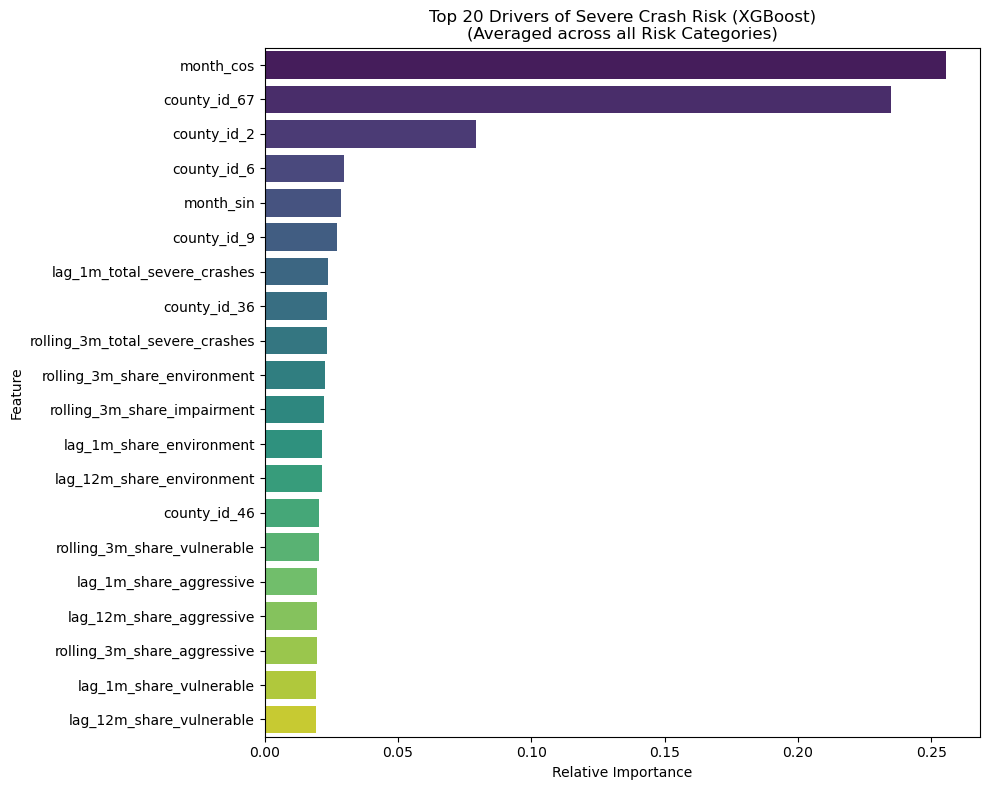

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ==============================================================================
# 1. DATA PREPARATION
# ==============================================================================
def prepare_data_for_modeling(df):
    """
    Splits data into X (features) and Y (targets) and performs Time-Series Split.
    """
    print("--- Preparing Data ---")
    
    # 1. Define Targets (The Risk Proportions)
    target_cols = ['share_impairment', 'share_aggressive', 'share_vulnerable', 'share_environment']
    
    # 2. Define Features
    # We exclude the 'date' and raw 'CRASH_YEAR'/'CRASH_MONTH' from training 
    # (using cyclical month_sin/cos instead)
    # We also exclude the target columns themselves and the raw 'total_severe_crashes' (unless used as a feature)
    
    # Drop non-feature columns
    drop_cols = target_cols + ['date', 'CRASH_YEAR', 'CRASH_MONTH', 'total_severe_crashes']
    
    # Handle COUNTY categorical: One-Hot Encode
    # County IDs (1-67) are nominal, not ordinal. 
    df_encoded = pd.get_dummies(df, columns=['COUNTY'], prefix='county_id')
    
    # Identify Feature Columns (everything left after dropping targets/meta)
    feature_cols = [c for c in df_encoded.columns if c not in drop_cols]
    
    print(f"Features ({len(feature_cols)}): {feature_cols}")
    print(f"Targets ({len(target_cols)}): {target_cols}")
    
    # 3. Time-Based Split
    # Train: 2005 - 2022
    # Test: 2023+ (The most recent complete year data available)
    train_mask = df_encoded['CRASH_YEAR'] <= 2022
    test_mask = df_encoded['CRASH_YEAR'] >= 2023
    
    X_train = df_encoded.loc[train_mask, feature_cols]
    y_train = df_encoded.loc[train_mask, target_cols]
    
    X_test = df_encoded.loc[test_mask, feature_cols]
    y_test = df_encoded.loc[test_mask, target_cols]
    
    print(f"Train Shape: {X_train.shape}")
    print(f"Test Shape:  {X_test.shape}")
    
    return X_train, y_train, X_test, y_test, feature_cols, target_cols

# ==============================================================================
# 2. MODEL TRAINING & EVALUATION LOOP
# ==============================================================================
def train_and_evaluate(X_train, y_train, X_test, y_test, target_cols):
    """
    Trains multiple models and compares MAE (Mean Absolute Error).
    """
    # Define Models
    models = {
        "Ridge_Baseline": Ridge(alpha=1.0),
        
        "Random_Forest": RandomForestRegressor(
            n_estimators=100, 
            max_depth=10, 
            random_state=42, 
            n_jobs=-1
        ),
        
        "XGBoost": XGBRegressor(
            n_estimators=200, 
            learning_rate=0.05, 
            max_depth=5, 
            random_state=42,
            n_jobs=-1
        )
    }
    
    results = []
    trained_models = {}
    
    print("\n--- Training Models ---")
    
    for name, model in models.items():
        print(f"Training {name}...")
        
        # Wrap in MultiOutputRegressor to handle 4 targets simultaneously
        # (XGBoost can do this natively, but wrapper ensures consistent API for all)
        wrapper = MultiOutputRegressor(model)
        wrapper.fit(X_train, y_train)
        
        # Predict
        preds = wrapper.predict(X_test)
        preds_df = pd.DataFrame(preds, columns=target_cols, index=y_test.index)
        
        # Calculate Errors per Target
        model_metrics = {'Model': name}
        
        # Global MAE (Average across all 4 targets)
        global_mae = mean_absolute_error(y_test, preds)
        model_metrics['Global_MAE'] = global_mae
        
        # Per-Target MAE
        for col in target_cols:
            mae = mean_absolute_error(y_test[col], preds_df[col])
            model_metrics[f'MAE_{col}'] = mae
            
        results.append(model_metrics)
        trained_models[name] = wrapper

    # Create Comparison Table
    results_df = pd.DataFrame(results)
    return results_df, trained_models

# ==============================================================================
# 3. FEATURE IMPORTANCE VISUALIZATION
# ==============================================================================
def plot_feature_importance(model_wrapper, feature_names, target_names, model_name="XGBoost"):
    """
    Plots feature importance. For MultiOutput, we average importance across estimators.
    """
    print(f"\n--- Extracting Feature Importance ({model_name}) ---")
    
    # Extract importances from each estimator (one per target)
    importances_list = []
    for idx, estimator in enumerate(model_wrapper.estimators_):
        if hasattr(estimator, 'feature_importances_'):
            importances_list.append(estimator.feature_importances_)
        elif hasattr(estimator, 'coef_'): # For Linear models
            importances_list.append(np.abs(estimator.coef_))
            
    if not importances_list:
        print("Model does not support feature importance attributes.")
        return

    # Average importance across all 4 targets to get "Overall Systemic Risk Factors"
    avg_importance = np.mean(importances_list, axis=0)
    
    # Create DataFrame
    feat_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': avg_importance
    }).sort_values(by='Importance', ascending=False)
    
    # Plot Top 20
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feat_imp.head(20), palette='viridis')
    plt.title(f'Top 20 Drivers of Severe Crash Risk ({model_name})\n(Averaged across all Risk Categories)')
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()
    
    return feat_imp

# ==============================================================================
# MAIN EXECUTION
# ==============================================================================
# Assumes 'df_forecast' exists from the previous step
if 'df_forecast' in locals():
    # 1. Prepare
    X_train, y_train, X_test, y_test, feat_cols, targ_cols = prepare_data_for_modeling(df_forecast)
    
    # 2. Train & Eval
    metrics_df, models_dict = train_and_evaluate(X_train, y_train, X_test, y_test, targ_cols)
    
    print("\n--- Model Performance (MAE: Lower is Better) ---")
    print("Interpretation: A value of 0.05 means the prediction is off by 5 percentage points.")
    print(metrics_df.round(4))
    
    # 3. Visualize Importance (Using XGBoost as it's usually best for this data)
    best_model_name = "XGBoost" 
    if best_model_name in models_dict:
        fi_df = plot_feature_importance(models_dict[best_model_name], feat_cols, targ_cols, best_model_name)
else:
    print("Error: 'df_forecast' not found. Please run the previous data generation code first.")